# Time Augumentation

- [LSTM Autoencoder for Extreme Rare Event Classification in Keras](https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pd.options.plotting.backend = "plotly"

from datetime import datetime, timedelta
from pathlib import Path

import tensorflow as tf
print(tf.__version__)

from tsa_aug import *

2.3.1


# DataFrame 

In [2]:
# DATA_PATH = Path("../DATA/denso/20200601/2020-05-07_124628_r4.csv")
DATA_PATH = Path("./2020-05-07_124628_r4.csv")

def read_data(path):
    df = pd.read_csv(str(path))
    df["Time"] = pd.to_datetime( datetime(2020,1,1,0,0) + pd.to_timedelta(df["Time"], unit="s") )
    df.set_index("Time", inplace=True)
    return df

def select_data(df):
    df_data = df.filter(regex="^Option0(0|1|2)_(x|y|z)$").copy()
    return df_data

def select_target(df):
    df_targets = df[["element_work"]].copy()
    return df_targets

def select_df_by_range(df, start_time, end_time):
    return df[start_time:end_time]

def draw_graph(xs, ys=None, figsize=None):
    if ys is None:
        if figsize is None:
            figsize=(18,2)
        plt.figure(figsize=figsize);
        if type(xs) is pd.DataFrame:
            xs = xs.values
        plt.plot(xs);
    else:
        if figsize is None:
            figsize=(18,4)
        fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=figsize)
        if type(xs) is pd.DataFrame:
            xs = xs.values
        if type(ys) is pd.DataFrame:
            ys = ys.values
        ax1.plot(xs)
        ax2.plot(ys)

def set_random_seed(seed=43):
    seed = 123
    import tensorflow as tf
    import random
    import os
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHseed"] = str(seed)

In [3]:
df = read_data(DATA_PATH)
print(df.shape)

df_data = select_data(df)
df_targets = select_target(df)
data_column_names = list(df_data.columns)

(56021, 31)


## sampling rate

In [4]:
df_data.index.to_series().diff().mean()

# 1コマの時間(ms)
data_sampling_period = df_data.index.to_series().diff().mean().value/1e6
print(f"data_sampling_period = {data_sampling_period}")

# fps
data_sampling_rate = 1e9/df_data.index.to_series().diff().mean().value
print(f"data_sampling_rate = {data_sampling_rate}")

RESAMPLE_PEDIOD = 200
print(data_sampling_period, RESAMPLE_PEDIOD)

data_sampling_period = 33.763769
data_sampling_rate = 29.617546548194902
33.763769 200


# 1周期分の時系列データのサンプリング

## candidate #1

(445, 9) (445, 1)


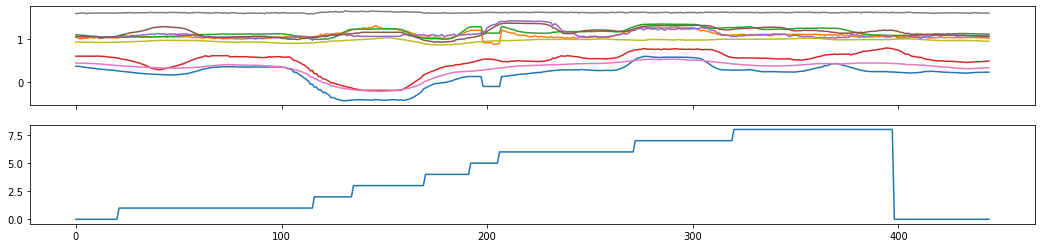

In [5]:
# START_TIME = "2020-01-01 00:05:12 5000"
CYCLE_START_TIME1 = datetime(2020, 1, 1, 0, 6, 20, 0)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME1 = datetime(2020, 1, 1, 0, 6, 35, 0)


df_data_sample1 = select_df_by_range(df_data, CYCLE_START_TIME1, CYCLE_END_TIME1)
df_targets_sample1 = select_df_by_range(df_targets, CYCLE_START_TIME1, CYCLE_END_TIME1)
print(df_data_sample1.shape, df_targets_sample1.shape)

draw_graph(df_data_sample1, df_targets_sample1)

## candidate #2

In [6]:
# CYCLE_START_TIME2 = datetime(2020, 1, 1, 0, 23, 40, 0)
CYCLE_START_TIME2 = datetime(2020, 1, 1, 0, 23, 51, 0)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME2 = datetime(2020, 1, 1, 0, 24, 1, 950000)


df_data_sample2 = select_df_by_range(df_data, CYCLE_START_TIME2, CYCLE_END_TIME2)
df_targets_sample2 = select_df_by_range(df_targets, CYCLE_START_TIME2, CYCLE_END_TIME2)
# print(df_targets.value_counts())
# print(df_data_sample2.shape, df_targets_sample2.shape)

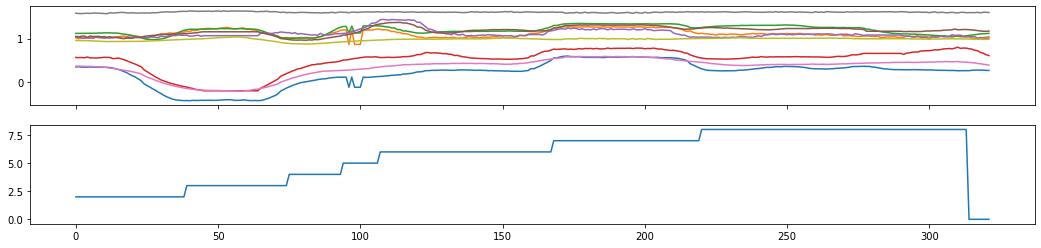

In [7]:
draw_graph(df_data_sample2, df_targets_sample2)

## candidate #3

(470, 9) (470, 1)


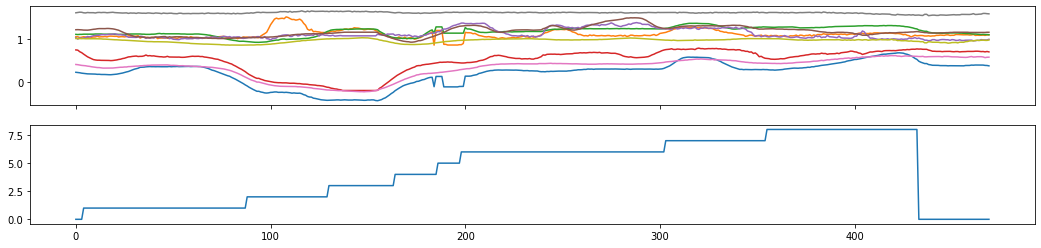

In [8]:
CYCLE_START_TIME3 = datetime(2020, 1, 1, 0, 17, 30, 600000)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME3 = datetime(2020, 1, 1, 0, 17, 46, 500000)


df_data_sample3 = select_df_by_range(df_data, CYCLE_START_TIME3, CYCLE_END_TIME3)
df_targets_sample3 = select_df_by_range(df_targets, CYCLE_START_TIME3, CYCLE_END_TIME3)
print(df_data_sample3.shape, df_targets_sample3.shape)

draw_graph(df_data_sample3, df_targets_sample3)

## candidate #4

(4432, 9) (4432, 1)


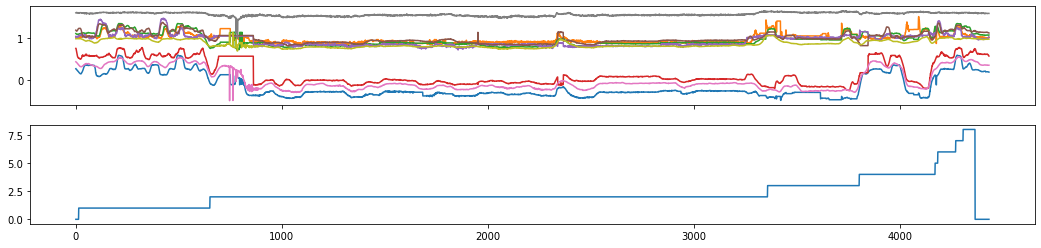

In [9]:
CYCLE_START_TIME4 = datetime(2020, 1, 1, 0, 10, 18, 650000)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME4 = datetime(2020, 1, 1, 0, 12, 47, 500000)


df_data_sample4 = select_df_by_range(df_data, CYCLE_START_TIME4, CYCLE_END_TIME4)
df_targets_sample4 = select_df_by_range(df_targets, CYCLE_START_TIME4, CYCLE_END_TIME4)
print(df_data_sample4.shape, df_targets_sample4.shape)


draw_graph(df_data_sample4, df_targets_sample4)

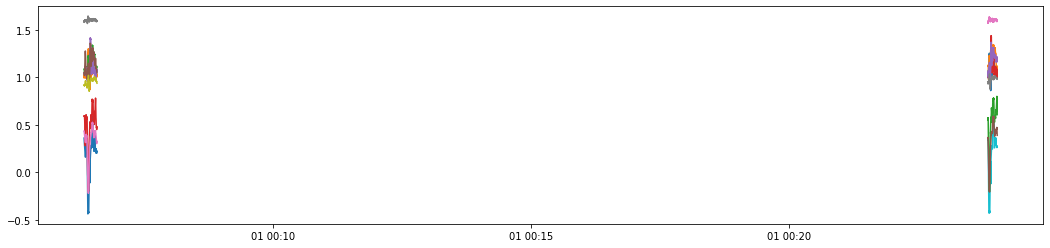

In [10]:
plt.figure(figsize=(18,4))
plt.plot(df_data_sample1)
plt.plot(df_data_sample2);
# plt.plot(df_data_sample3);
# plt.plot(df_data_sample4);

# Data Augument

In [11]:
RANDOM_SEED = 101
set_random_seed(RANDOM_SEED)

## repeat transform

In [12]:
def transform_n_times_Xy(xs, ys, fx, fy, params):
    xss, yss = [], []
    for param in loops:
        xs_new = fx(xs, param)
        ys_new = fy(ys, param)
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def stretches_n_times_Xy(xs, ys, loops):
    xss, yss = [], []
    for i in loops:
        xs_new = time_stretch(xs, i)
        ys_new = time_stretch(ys, i, kind="nearest")
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def partial_stretches_n_times_Xy(xs, ys, rep_stretches):
    xss, yss = [], []
    for stretches in rep_stretches:
#         print(stretches)
        xs_new = partial_time_stretch(xs, stretches)
        ys_new = partial_time_stretch(ys, stretches, kind="nearest")
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def time_warps_n_times_Xy(xs, ys, n_times, n_knots=500):
    xss, yss = [], []
    for _ in range(n_times):
        xs_new, ys_new = time_warp_Xy(xs, ys, n_knots=n_knots)
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def merge_data(xss):
    return np.concatenate(xss, axis=0)

In [13]:
rep_stretches = []
for s in np.arange(1, 3.1, 0.1):
    for d in np.arange(0.1, 0.5, 0.1):
        for x in np.arange(0, 1.1, d):
            rep_stretches.append([[x, x+d, s]])

print(len(rep_stretches))

504


(261471, 9) (261471, 1) (189153, 9) (189153, 1) (189153, 9) (189153, 1)
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
generate_random_curves:sigma 0.2
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0}


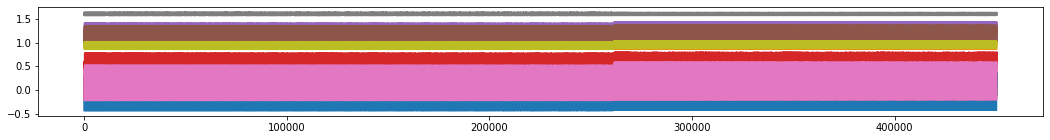

In [14]:
X1_, y1_ = partial_stretches_n_times_Xy(df_data_sample1.values, df_targets_sample1.values, rep_stretches=rep_stretches)
X2_, y2_ = partial_stretches_n_times_Xy(df_data_sample2.values, df_targets_sample2.values, rep_stretches=rep_stretches)
X3_, y3_ = partial_stretches_n_times_Xy(df_data_sample2.values, df_targets_sample2.values, rep_stretches=rep_stretches)

print(X1_.shape, y1_.shape, X2_.shape, y2_.shape, X3_.shape, y3_.shape)


X1, y1 = time_warps_n_times_Xy(X1_, y1_, n_times=10)
X2, y2 = time_warps_n_times_Xy(X2_, y2_, n_times=10)
# X3, y3 = time_warps_n_times_Xy(X3_, y3_, n_times=10)

X_ = merge_data([X1_, X2_])
y_ = merge_data([y1_, y2_])
 
X_stretched = jitter(X_, sigma=0.005)
y_stretched = y_

draw_graph(X_)

print(set(y_stretched.flatten().tolist()))

# 前処理 (np)
```
# def clipping_data(xs):
#     c_min, c_max = np.percentile(xs, [0.5, 99.5], axis=0)
#     return np.clip(xs, c_min, c_max)
```

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def resample_data(xs):
    return resampling(xs, src_period=data_sampling_period, dst_period=RESAMPLE_PEDIOD, kind="linear")

def resample_targets(xs):
    return resampling(xs, src_period=data_sampling_period, dst_period=RESAMPLE_PEDIOD, kind="nearest")

def preprocess(xs, pipes):
    for p in pipes:
        xs = p(xs.copy())
    return xs

def clipping_data(xs):
    MIN_PERC, MAX_PERC = 2.5, 97.5
    c_min, c_max = np.percentile(xs, [MIN_PERC, MAX_PERC], axis=0)
    return np.clip(xs, c_min, c_max)

# TODO
sc = StandardScaler()
sc.fit(X_stretched)
def scaling_data(xs):
    global sc
    return sc.transform(xs)

ohe = OneHotEncoder(sparse=False)
ohe.fit(y_stretched)
def ohe_targets(xs):
    xs = xs.reshape(-1, 1)
    return ohe.transform(xs).astype(dtype="int32")

## Training Data

In [16]:
X_train = preprocess(X_stretched, [resample_data, clipping_data, scaling_data])
y_train = preprocess(y_stretched, [resample_targets, ohe_targets])

print(X_train.shape,  y_train.shape)
print(X_train.mean(axis=0))

(76074, 9) (76074, 9)
[-2.45262469e-05  1.69879704e-02  1.71748331e-03 -2.12316715e-04
 -1.60348269e-03  4.33154653e-03  5.56280917e-04  2.91999528e-03
  2.53564398e-03]


## ~~Validation Data~~ All data

In [17]:
# ohe_targets(resample_targets(df_targets_valid.values))

In [18]:
# VALID_START_TIME = datetime(2020, 1, 1, 0, 27, 0)
VALID_START_TIME = datetime(2020, 1, 1, 0, 15, 0)
VALID_END_TIME =   datetime(2020, 1, 1, 0, 38, 0)

df_data_all = (read_data(DATA_PATH)
     .pipe(select_data)
#      .pipe(select_df_by_range, VALID_START_TIME, VALID_END_TIME) # all
    )#.iloc[:1000]
df_target_all = (read_data(DATA_PATH)
     .pipe(select_target)
#      .pipe(select_df_by_range, VALID_START_TIME, VALID_END_TIME) # all
    )#.iloc[:1000]
print(df_data_all.shape, df_target_all.shape)

X_all = preprocess(df_data_all.values, [resample_data, clipping_data, scaling_data])
y_all = preprocess(df_target_all.values, [resample_targets, ohe_targets])
print(X_all.shape, y_all.shape)
print(X_all.mean(axis=0))

(56021, 9) (56021, 1)
(9458, 9) (9458, 9)
[-0.25819568 -0.30453781 -0.48337002 -0.23060827 -0.47773488 -0.45891124
 -0.30517686 -0.60728454 -0.78835038]


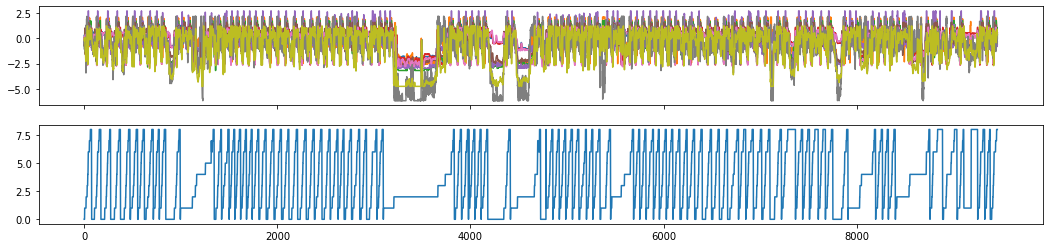

In [19]:
draw_graph(X_all, y_all.argmax(axis=1))

# temporalize

In [20]:
T, D = 100, 9

def temporalize(xs, ys, length):
    assert type(xs)==np.ndarray and xs.ndim==2
    assert type(ys)==np.ndarray and ys.ndim==2
    assert len(xs)==len(ys)
    assert type(length)==int
    
    out_x, out_y = [], []
    for i in range(len(xs)-length+1):
        out_x.append(xs[i:i+length, :])
        out_y.append(ys[i:i+length, :])
    return np.array(out_x), np.array(out_y)
    

In [21]:
X_ts_train, Y_ts_train = temporalize(X_train, X_train, T)
X_ts_all, y_ts_all = temporalize(X_all, y_all, T)

print(X_ts_all.shape, y_ts_all.shape)
print(X_ts_train.shape, np.allclose(X_ts_train, Y_ts_train))

(9359, 100, 9) (9359, 100, 9)
(75975, 100, 9) True


# Autoencoder

In [22]:
from tensorflow.keras.layers import Dense, SimpleRNN, Input, LSTM, Flatten, Bidirectional, Dropout, GRU
from tensorflow.keras.layers import RepeatVector, TimeDistributed

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
model = Sequential([
    Input(shape=(T,D)), # Noe, T=T, D=D
    LSTM(T, activation="tanh", use_bias=True, name="lstm_e1", 
        return_sequences=True,
        recurrent_activation='sigmoid',
        kernel_initializer='glorot_normal',
        dropout = 0.5,
        recurrent_initializer='orthogonal'),
    LSTM(T//2, activation="tanh", use_bias=True, name="lstm_e2", 
        return_sequences=False,
        recurrent_activation='sigmoid',
        kernel_initializer='glorot_normal',
        dropout = 0.5,
        recurrent_initializer='orthogonal'),
    RepeatVector(T),
    LSTM(T//2, activation="tanh", use_bias=True, name="lstm_d1", 
        return_sequences=True,
        recurrent_activation='sigmoid',
        kernel_initializer='glorot_normal',
        dropout = 0.5,
        recurrent_initializer='orthogonal'),
    LSTM(T, activation="tanh", use_bias=True, name="lstm_d2", 
        return_sequences=True,
        recurrent_activation='sigmoid',
        kernel_initializer='glorot_normal',
        dropout = 0.5,
        recurrent_initializer='orthogonal'), # must be return_sequences=True, if next is TimeDist
    TimeDistributed(Dense(D))
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_e1 (LSTM)               (None, 100, 100)          44000     
_________________________________________________________________
lstm_e2 (LSTM)               (None, 50)                30200     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 50)           0         
_________________________________________________________________
lstm_d1 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_d2 (LSTM)               (None, 100, 100)          60400     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 9)            909       
Total params: 155,709
Trainable params: 155,709
Non-trainable params: 0
__________________________________________________

In [24]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

In [25]:
es = EarlyStopping(patience=100, verbose=2, monitor="mse")
cp = ModelCheckpoint(filepath="saved_model_ae_01/", monitor="mse", save_best_only=True, verbose=1)
r = model.fit(X_ts_train, Y_ts_train, epochs=40, batch_size=2048, callbacks=[es, cp], verbose=2)

Epoch 1/40

Epoch 00001: mse improved from inf to 0.92719, saving model to saved_model_ae_01/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model_ae_01/assets
38/38 - 14s - loss: 0.9272 - mse: 0.9272 - mae: 0.7426
Epoch 2/40

Epoch 00002: mse improved from 0.92719 to 0.70568, saving model to saved_model_ae_01/
INFO:tensorflow:Assets written to: saved_model_ae_01/assets
38/38 - 14s - loss: 0.7057 - mse: 0.7057 - mae: 0.6449
Epoch 3/40

Epoch 00003: mse improved from 0.70568 to 0.54804, saving model to saved_model_ae_01/
INFO:tensorflow:Assets written to: saved_model_ae_01/assets
38/38 - 14s - loss: 0.5480 - mse: 0.5480 - mae: 0.5644
Epoch 4/40

Epoch 00004: mse improved from 0.54804 to 0.46939, saving model to saved_model_ae_01/
INFO:tensorflow:Assets written to

<AxesSubplot:>

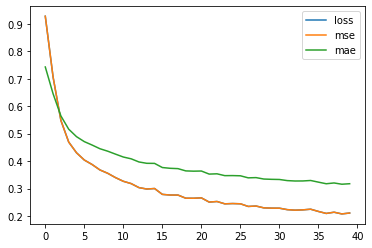

In [26]:
pd.DataFrame(r.history).plot()

In [27]:
# Get train MAE loss.
X_ts_pred = model.predict(X_ts_train)
# train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)1111111\^-a

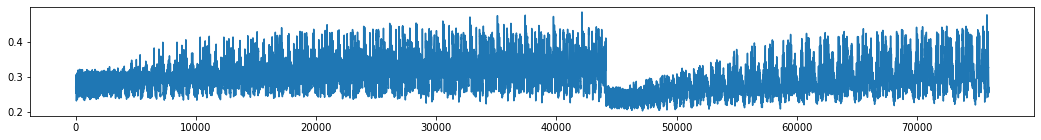

In [28]:
mae_loss = np.abs(X_ts_train - X_ts_pred).mean(axis=1).mean(axis=1)
mae_loss.shape
draw_graph(mae_loss)

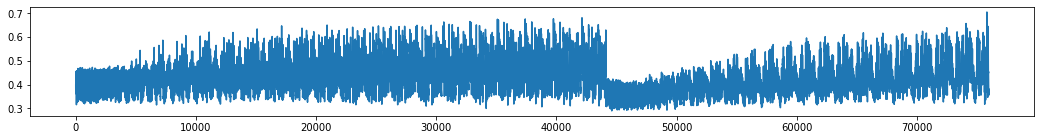

In [29]:
rmse_loss = np.sqrt(np.square(X_ts_train - X_ts_pred).mean(axis=1).mean(axis=1))
rmse_loss.shape
draw_graph(rmse_loss)

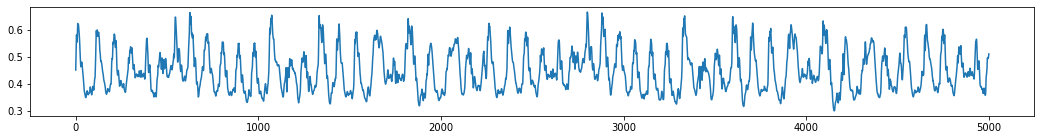

In [30]:
draw_graph(rmse_loss[30000:35000])

# predict all data

In [31]:
X_pred = model.predict(X_ts_all)

(9359, 9) (9359, 9)


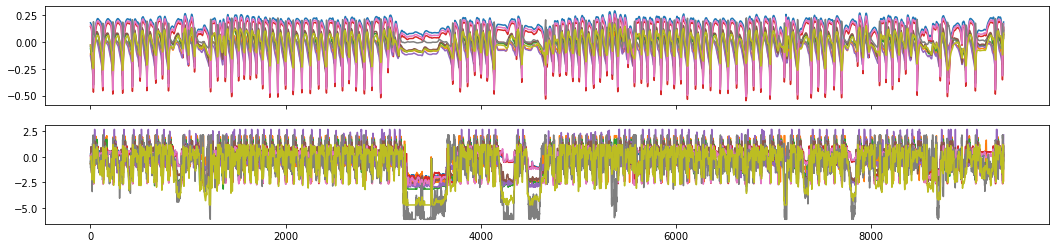

In [32]:
draw_graph(X_pred[:,0,:], X_ts_all[:,0,:])
print(X_pred[:,0,:].shape, X_ts_all[:,0,:].shape)

In [33]:
rmse = np.sqrt(np.square(X_pred-X_ts_all)).mean(axis=(1,2))
print(rmse.shape)

(9359,)


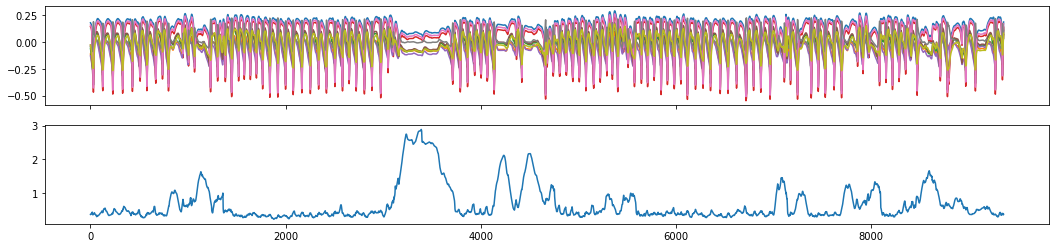

In [34]:
draw_graph(X_pred[:,0,:], rmse)

# 全体で予測

In [35]:
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import seaborn as sns

In [36]:
model = load_model("saved_model_10_01/")

In [37]:
START_TIME = df_data.index[0]
END_TIME = df_data.index[-1]

RULE = "200ms"

def resampling(df, rule, func):
    return df.resample(rule=rule).agg(func)

X_all_ = (read_data(DATA_PATH)
     .pipe(select_data)
     .pipe(select_df_by_range, START_TIME, END_TIME)
     .pipe(resampling, RULE, "mean")
    ).values.astype(dtype="float32")
y_all_ = (read_data(DATA_PATH)
     .pipe(select_target)
     .pipe(select_df_by_range, START_TIME, END_TIME)
     .pipe(resampling, RULE, "ffill")
#      .pipe(fillna)
     .pipe(pd.get_dummies, columns=["element_work"], drop_first=False)
    ).values.astype(dtype="int32")

print(X_all_.shape, y_all_.shape)

X_all = preprocess(X_all_, [scaling_data])
y_all = y_all_ #preprocess(y_all_, [astype_int32])

print(X_all.shape, y_all.shape)

(9458, 9) (9458, 9)
(9458, 9) (9458, 9)


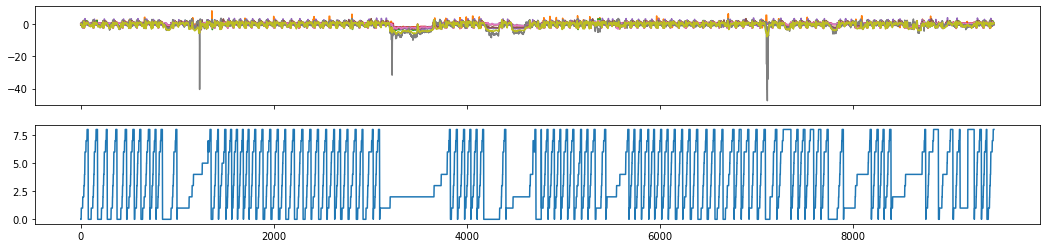

In [38]:
draw_graph(X_all, y_all.argmax(axis=1))

In [39]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

generator_all = TimeseriesGenerator(X_all, y_all, length=T, batch_size=4000, shuffle=False)

In [40]:
ys_pred = []
ys_true = []

for x, y in generator_all:
    y_pred = model.predict(x)
    ys_pred.append(y_pred)
    ys_true.append(y)

ys_prob = np.concatenate(ys_pred, axis=0).max(axis=1)
ys_pred = np.concatenate(ys_pred, axis=0).argmax(axis=1)
ys_true = np.concatenate(ys_true, axis=0).argmax(axis=1)

ys_pred.shape, ys_true.shape, ys_prob.shape

((9358,), (9358,), (9358,))

In [41]:
print(classification_report(ys_true, ys_pred))

              precision    recall  f1-score   support

           0       0.39      0.36      0.38      1166
           1       0.59      0.52      0.55      1844
           2       0.64      0.67      0.65      1340
           3       0.68      0.80      0.74       677
           4       0.68      0.55      0.61       902
           5       0.40      0.51      0.45       269
           6       0.85      0.80      0.83      1190
           7       0.60      0.94      0.73       635
           8       0.83      0.78      0.80      1335

    accuracy                           0.65      9358
   macro avg       0.63      0.66      0.64      9358
weighted avg       0.65      0.65      0.64      9358



In [42]:
# plt.figure(figsize=(8,6))
# sns.heatmap(confusion_matrix(ys_true, ys_pred), annot=True, fmt="g");
accuracy_score(ys_true, ys_pred)

0.645864500961744

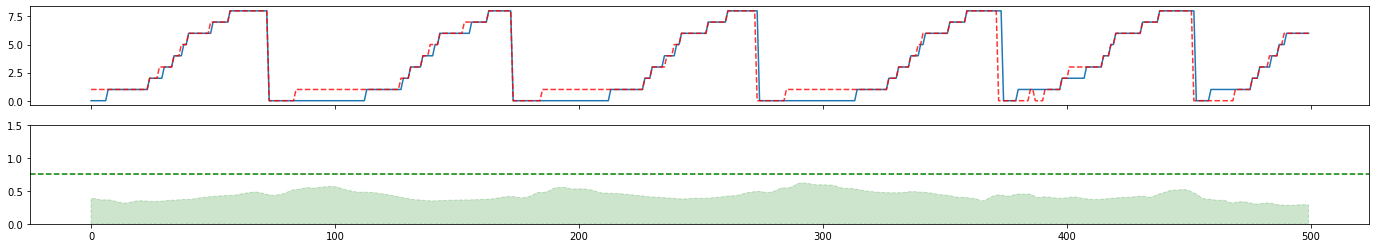

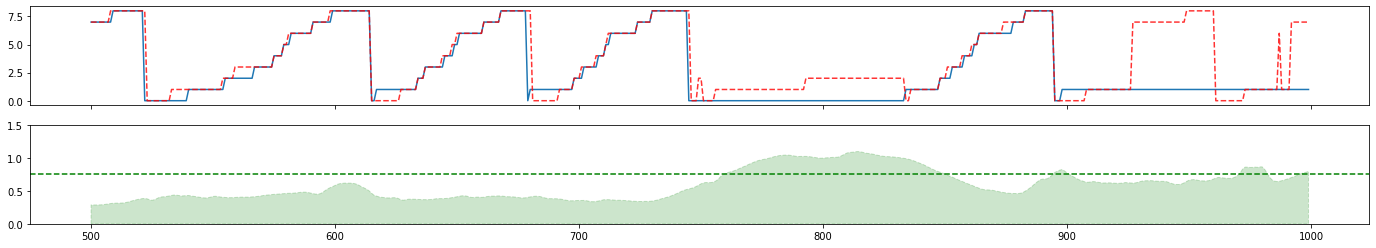

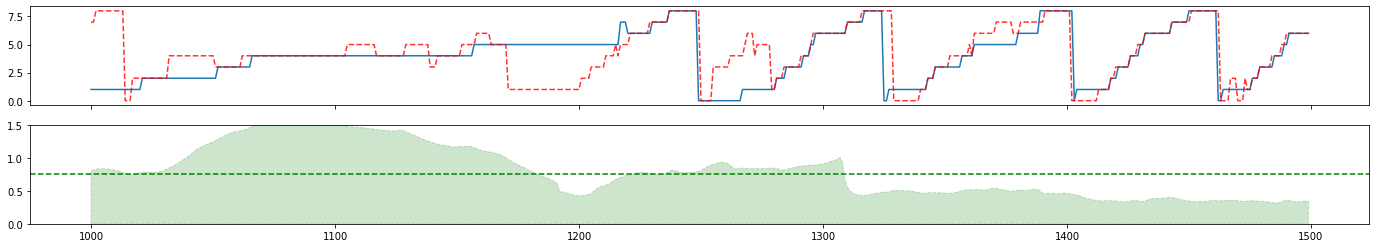

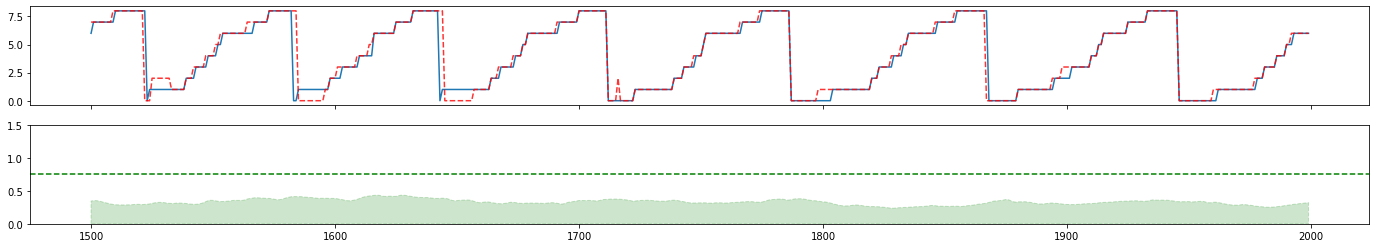

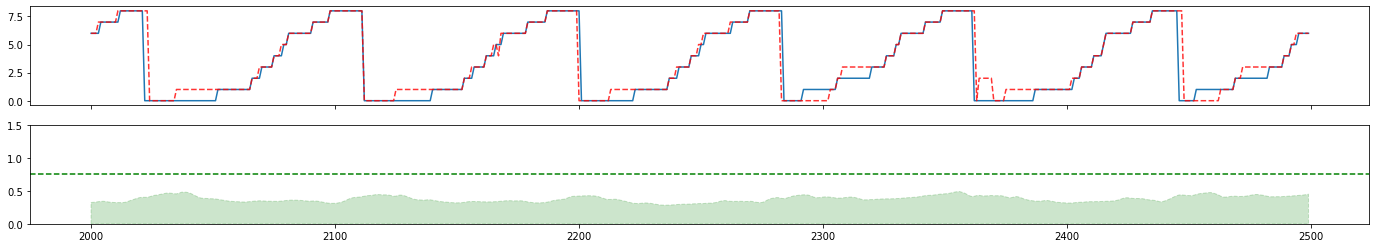

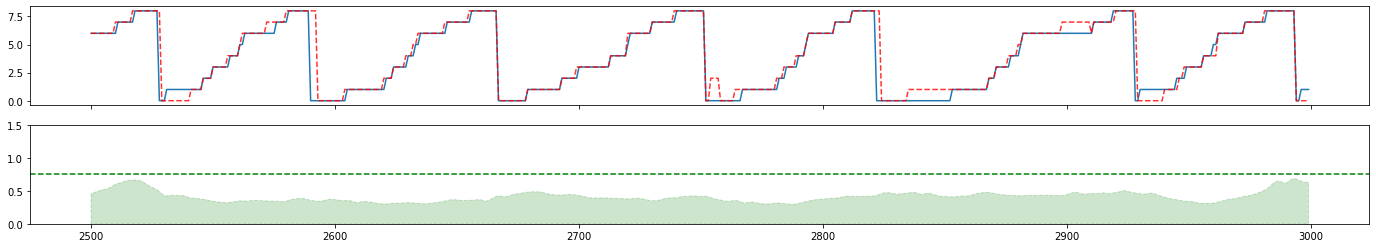

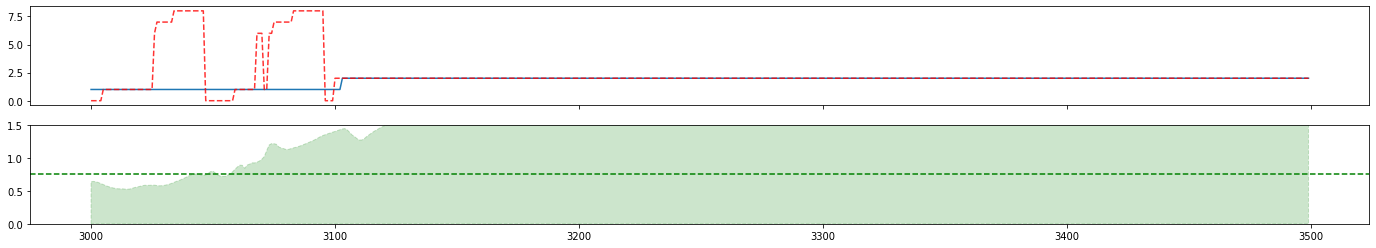

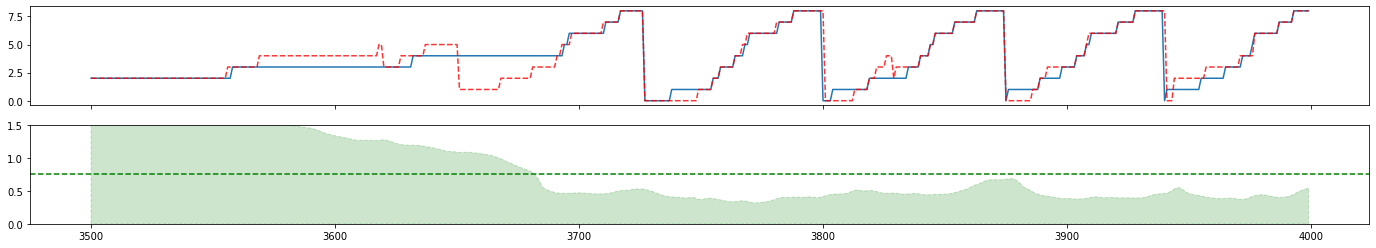

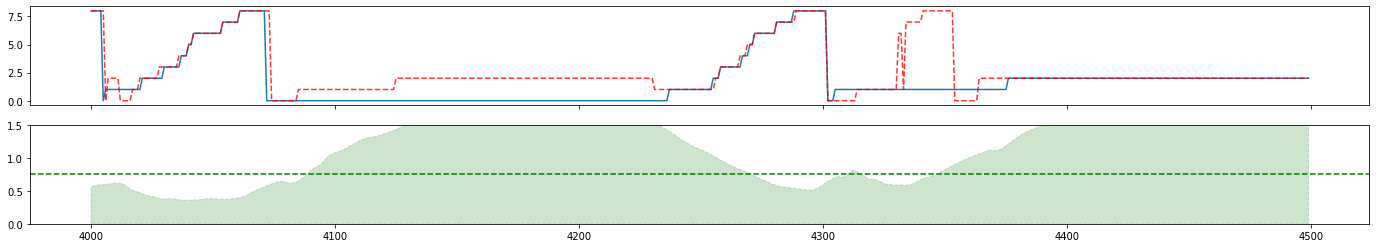

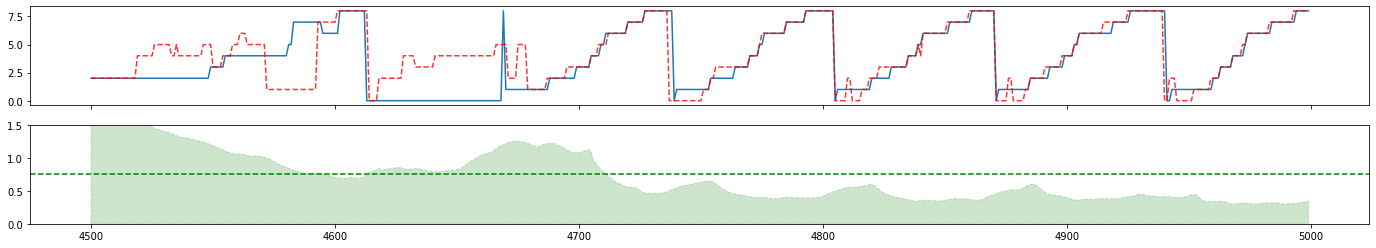

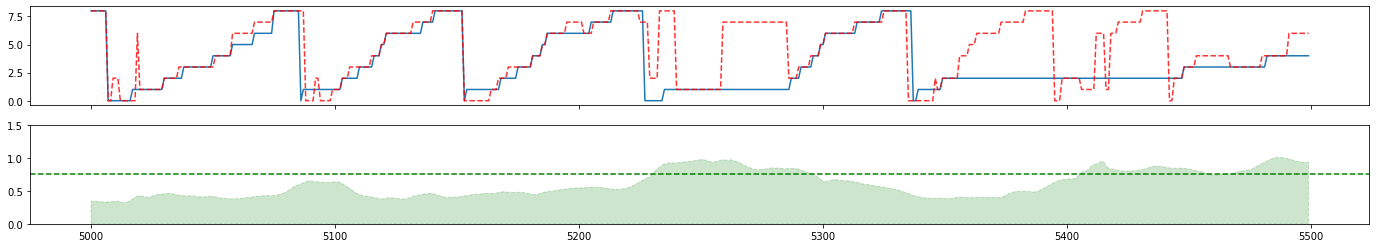

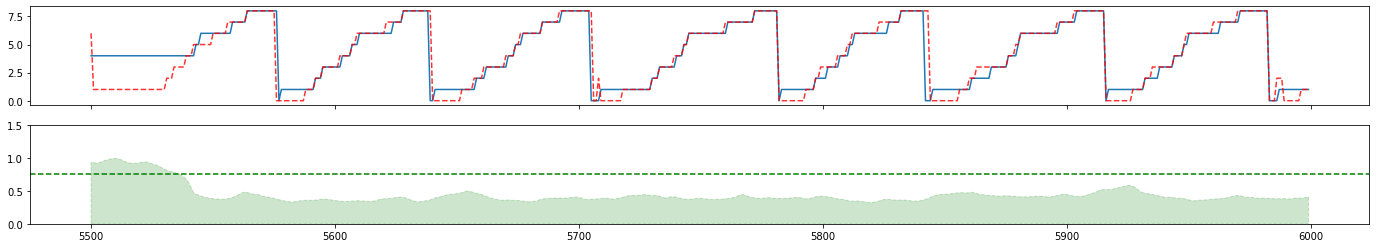

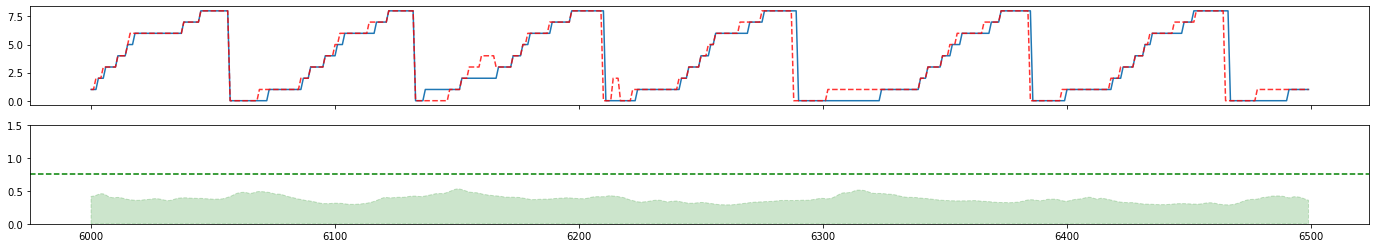

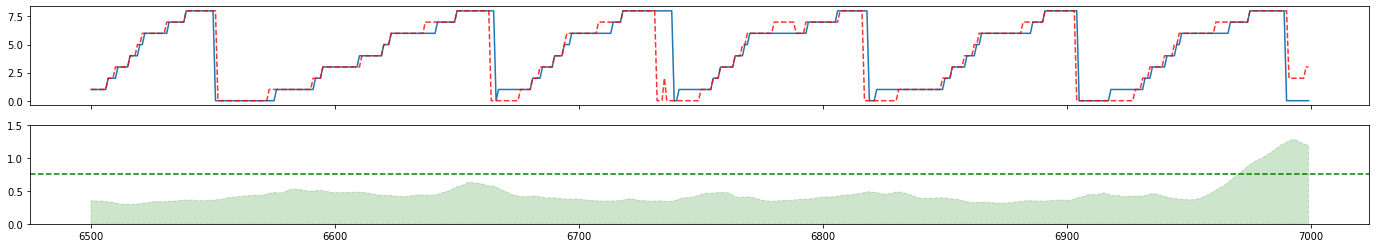

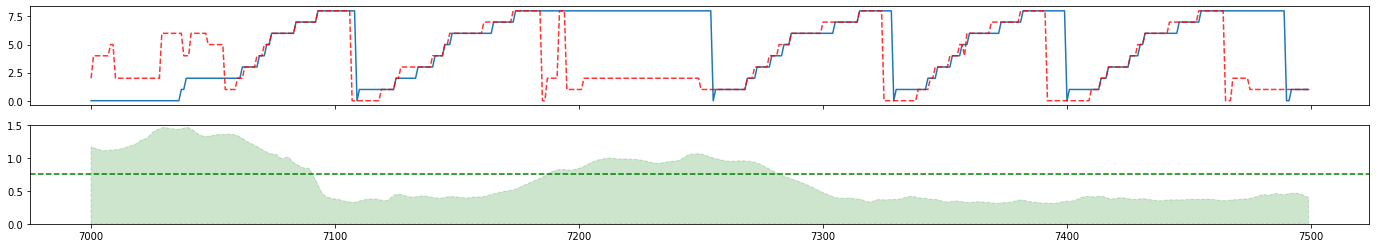

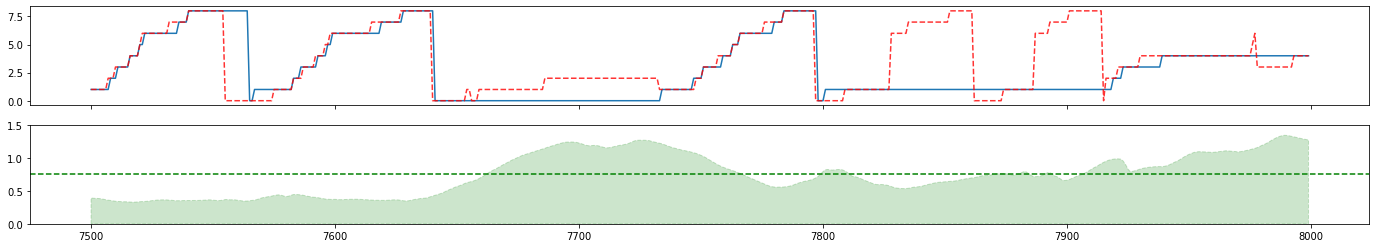

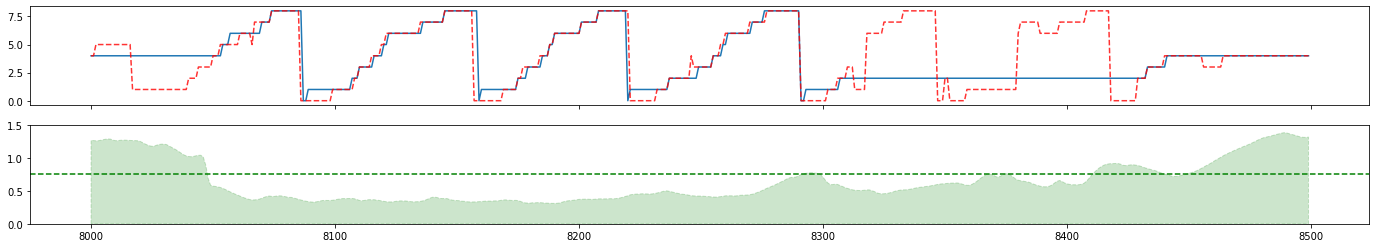

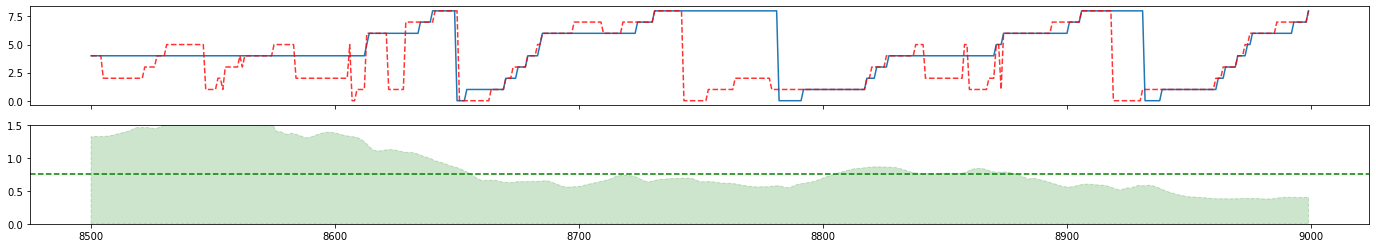

In [46]:
def plot_result(start=0, end=len(ys_pred)):
    cmap = plt.get_cmap("tab10") # ココがポイント
    fig, (ax1 ,ax2) = plt.subplots(2, 1, figsize=(24,4), sharex=True)
    ax1.plot(range(start,end), ys_true[start:end])
    ax1.plot(range(start,end), ys_pred[start:end], alpha=0.8, linestyle="--", color="red");
    ax2.fill_between(range(start,end), rmse[50:][start:end], alpha=0.2, linestyle="--", color="green");
    ax2.set_ylim([0,1.5])
    ax2.axhline(y=0.75, linestyle="--", color="green")
    
    
# plot_result()

duration = 500
start, end = 0, duration
while True:
#     print(start, end)
    plot_result(start, end)
    start += duration
    end += duration
    if end>len(ys_pred):
        break

# Last